In [17]:
import os
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from dotenv import load_dotenv
import datetime

from psycopg2 import sql, connect
from sqlalchemy import create_engine, text

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from train_test.general import train_test_bookies_comparison, display_train_test_bookies_comparison, train_test
from train_test.split import train_test_split_expanding_windows, train_test_split_sliding_windows
from feature_eng.odds import bookie_prediction, prob_by_bookies
from train_test.metrics import accuracy_fn, classwise_ECE_fn, f_mesure_fn, log_loss_fn, mse_loss_fn, precision_fn, recall_fn
from feature_eng.team_stats import goal_stats, elo_scores, glicko2_scores, trueskill_scores

from feature_eng.format_df import merge_sofifa_fbref_results, format_sofifa_fbref_data, add_signals


In [2]:

load_dotenv("./../../secrets.env")
DB_USER = 'kube'
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = 'localhost'
DB_PORT = 8110
DB_NAME = 'optimsportbets-db'

DB_TN_FBREF_RESULTS = 'fbref_results'
DB_TN_ODDS = 'soccer_odds'
DB_TN_SOFIFA_TEAMS_STATS = 'sofifa_teams_stats'
DB_TN_MODELS_RESULTS = 'models_results'
DB_TN_OPTIM_RESULTS = 'optim_results'

In [3]:
connection_url = f'postgresql+psycopg2://{(DB_USER)}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(connection_url)

with engine.connect() as connection:
    query = text(f"SELECT * FROM {DB_TN_FBREF_RESULTS}")
    fbref_results_df = pd.read_sql(query, connection)
    sofifa_teams_stats_df = pd.read_sql(f'SELECT * FROM {DB_TN_SOFIFA_TEAMS_STATS}', connection)

In [4]:
date_stop = datetime.datetime.now()
fbref_results_df__sofifa_merged = merge_sofifa_fbref_results(fbref_results_df, sofifa_teams_stats_df)
fbref_results_df__sofifa_merged__data_formated = format_sofifa_fbref_data(fbref_results_df__sofifa_merged, date_stop=date_stop)
fbref_results_df__sofifa_merged__data_formated__signals_added = add_signals(fbref_results_df__sofifa_merged__data_formated, date_stop=date_stop)

rule_is_before_datetime = fbref_results_df__sofifa_merged__data_formated__signals_added["datetime"] < date_stop
fbref_results_df__sofifa_merged__data_formated__signals_added__train = fbref_results_df__sofifa_merged__data_formated__signals_added[rule_is_before_datetime]
fbref_results_df__sofifa_merged__data_formated__signals_added__infer = fbref_results_df__sofifa_merged__data_formated__signals_added[~rule_is_before_datetime]

In [15]:
X_col_sofifa =  ['home_overall', 'home_attack', 
            'home_midfield', 'home_defence', 'home_transfer_budget', 'home_club_worth', 'home_defence_domestic_prestige', 'home_international_prestige', 
            'home_players', 'home_starting_xi_average_age', 'home_whole_team_average_age', 'away_overall', 'away_attack', 'away_midfield', 'away_defence', 
            'away_transfer_budget', 'away_club_worth', 'away_defence_domestic_prestige', 'away_international_prestige', 'away_players', 
            'away_starting_xi_average_age', 'away_whole_team_average_age']

X_col_scores = [
    'elo_home_before', 'elo_away_before',
    'home_team_number_of_match_played', 'away_team_number_of_match_played',
    'glicko2_home_before', 'glicko2_away_before', 'glicko2_rd_home_before',
    'glicko2_rd_away_before', 'glicko2_vol_home_before',
    'glicko2_vol_away_before', 'trueskill_home_before',
    'trueskill_away_before']

Y_col = 'FTR'

X_col = X_col_sofifa + X_col_scores

pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])

In [6]:
train_test_split_fn_exp = lambda df : train_test_split_expanding_windows(df, split=5, test_prop=0.2, date_col="date")
train_test_split_fn_slid = lambda df : train_test_split_sliding_windows(df, split=5, test_prop=0.2, date_col="date")
result_df_all_splits = False
m = 10
beta = 1
metrics_mean, metrics, _ = train_test(fbref_results_df__sofifa_merged__data_formated__signals_added__train,
                                       pipeline, X_col, Y_col, train_test_split_fn_exp, result_df_all_splits, m, beta)
train_test_metrics = pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})
train_test_metrics


,metrics,values
0,accuracy,0.519206
1,weighted_accuracy,0.664474
2,accuracy_home,0.590983
3,accuracy_draw,0.735618
4,accuracy_away,0.711812
5,macro_avg_recall,0.446168
6,micro_avg_recall,0.519206
7,weighted_recall,0.519206
8,recall_home,0.845425
9,recall_draw,0.000741


In [7]:
metrics_mean, metrics, _ = train_test(fbref_results_df__sofifa_merged__data_formated__signals_added__train, pipeline, X_col, Y_col, train_test_split_fn_slid, result_df_all_splits, m, beta)
train_test_metrics = pd.DataFrame({'metrics': metrics_mean.keys(), 'values': metrics_mean.values()})
train_test_metrics

,metrics,values
0,accuracy,0.520469
1,weighted_accuracy,0.665765
2,accuracy_home,0.594590
3,accuracy_draw,0.734175
4,accuracy_away,0.712173
5,macro_avg_recall,0.446883
6,micro_avg_recall,0.520469
7,weighted_recall,0.520469
8,recall_home,0.849980
9,recall_draw,0.003394


In [8]:
# Récupérer le modèle (LogisticRegression) à partir du pipeline
model = pipeline.named_steps['model']

# Récupérer les coefficients de la régression logistique
coefficients = model.coef_[0]  # Coefficients pour chaque feature

# Associer les coefficients avec les noms des features
feature_importance = pd.DataFrame({
    'Feature': X_col,
    'Importance': coefficients
})

# Trier par importance absolue
feature_importance['Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Afficher l'importance des features
print(feature_importance)

                             Feature  Importance
25  away_team_number_of_match_played    0.201971
32             trueskill_home_before    0.191622
26               glicko2_home_before    0.176059
24  home_team_number_of_match_played    0.167112
23                   elo_away_before    0.141819
22                   elo_home_before    0.136498
0                       home_overall    0.117439
18       away_international_prestige    0.105628
14                      away_defence    0.096448
27               glicko2_away_before    0.094480
21       away_whole_team_average_age    0.083883
19                      away_players    0.081848
13                     away_midfield    0.079457
3                       home_defence    0.072576
11                      away_overall    0.071746
5                    home_club_worth    0.070626
15              away_transfer_budget    0.055550
33             trueskill_away_before    0.053558
31           glicko2_vol_away_before    0.047809
2                   

In [9]:

pipeline.fit(fbref_results_df__sofifa_merged__data_formated__signals_added__train[X_col], fbref_results_df__sofifa_merged__data_formated__signals_added__train[Y_col])
fbref_results_df__sofifa_merged__data_formated__signals_added__infer = fbref_results_df__sofifa_merged__data_formated__signals_added__infer.copy()
fbref_results_df__sofifa_merged__data_formated__signals_added__infer.loc[:, 'pred'] = pipeline.predict(fbref_results_df__sofifa_merged__data_formated__signals_added__infer[X_col])
fbref_results_df__sofifa_merged__data_formated__signals_added__infer.loc[:, 'prob_home_win'] = pipeline.predict_proba(fbref_results_df__sofifa_merged__data_formated__signals_added__infer[X_col])[:, 2]
fbref_results_df__sofifa_merged__data_formated__signals_added__infer.loc[:, 'prob_draw'] = pipeline.predict_proba(fbref_results_df__sofifa_merged__data_formated__signals_added__infer[X_col])[:, 1]
fbref_results_df__sofifa_merged__data_formated__signals_added__infer.loc[:, 'prob_away_win'] = pipeline.predict_proba(fbref_results_df__sofifa_merged__data_formated__signals_added__infer[X_col])[:, 0]


In [10]:
selected_features = []
log_losses = []

# Liste des features disponibles
available_features = X_col

# Feature selection avec log loss
for i in range(len(available_features)):
    # Pour chaque itération, on ajoute une nouvelle feature à la liste des features sélectionnées
    best_log_loss = np.inf
    best_feature = None
    
    for feature in available_features:
        # Créer une liste des features actuelles
        current_features = selected_features + [feature]
        
        # Entraîner le pipeline sur le sous-ensemble de features
        metrics_mean, metrics, _ = train_test(fbref_results_df__sofifa_merged__data_formated__signals_added__train, 
                                              pipeline, current_features, Y_col, train_test_split_fn_exp, result_df_all_splits, m, beta)
        
        # Calculer la log loss
        current_log_loss = metrics_mean["log_loss"]
        
        # Si la log loss s'améliore, on garde cette feature comme la meilleure pour cette itération
        if current_log_loss < best_log_loss:
            best_log_loss = current_log_loss
            best_feature = feature
    
    # Ajouter la meilleure feature trouvée
    selected_features.append(best_feature)
    available_features.remove(best_feature)
    
    # Stocker la log loss pour cette itération
    log_losses.append(best_log_loss)

    # Afficher la progression
    print(f"Feature ajoutée : {best_feature}, Log Loss : {best_log_loss}")

# Résultats finaux sous forme de DataFrame
feature_selection_results = pd.DataFrame({
    'Selected_Features': selected_features,
    'Log_Loss': log_losses
})

# Afficher le résultat final
print(feature_selection_results)

Feature ajoutée : glicko2_away_before, Log Loss : 1.032641128266644
Feature ajoutée : glicko2_home_before, Log Loss : 0.9949308104349482
Feature ajoutée : away_overall, Log Loss : 0.992614363794454
Feature ajoutée : home_overall, Log Loss : 0.9876555227619395
Feature ajoutée : away_starting_xi_average_age, Log Loss : 0.9865651532878029
Feature ajoutée : away_international_prestige, Log Loss : 0.9859531592991958
Feature ajoutée : away_players, Log Loss : 0.9857189560650725
Feature ajoutée : glicko2_vol_away_before, Log Loss : 0.9856254117987856
Feature ajoutée : trueskill_home_before, Log Loss : 0.9853942662145728
Feature ajoutée : home_starting_xi_average_age, Log Loss : 0.9853631059733605
Feature ajoutée : home_whole_team_average_age, Log Loss : 0.985217965648508
Feature ajoutée : home_players, Log Loss : 0.9851726756382103
Feature ajoutée : glicko2_rd_away_before, Log Loss : 0.9851818548788629
Feature ajoutée : trueskill_away_before, Log Loss : 0.9851480769118257
Feature ajoutée : gl

In [16]:
selected_features = []
accuracys = []

# Liste des features disponibles
available_features = X_col

# Feature selection avec log loss
for i in range(len(available_features)):
    # Pour chaque itération, on ajoute une nouvelle feature à la liste des features sélectionnées
    best_accuracy = 0
    best_feature = None
    
    for feature in available_features:
        # Créer une liste des features actuelles
        current_features = selected_features + [feature]
        
        # Entraîner le pipeline sur le sous-ensemble de features
        metrics_mean, metrics, _ = train_test(fbref_results_df__sofifa_merged__data_formated__signals_added__train, 
                                              pipeline, current_features, Y_col, train_test_split_fn_exp, result_df_all_splits, m, beta)
        
        # Calculer la log loss
        current_accuracy = metrics_mean["accuracy"]
        
        # Si la log loss s'améliore, on garde cette feature comme la meilleure pour cette itération
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_feature = feature
    
    # Ajouter la meilleure feature trouvée
    selected_features.append(best_feature)
    available_features.remove(best_feature)
    
    # Stocker la log loss pour cette itération
    accuracys.append(best_accuracy)

    # Afficher la progression
    print(f"Feature ajoutée : {best_feature}, accuracy : {best_accuracy}")

# Résultats finaux sous forme de DataFrame
feature_selection_results = pd.DataFrame({
    'Selected_Features': selected_features,
    'accuracy': accuracys
})

# Afficher le résultat final
print(feature_selection_results)

Feature ajoutée : glicko2_away_before, accuracy : 0.4964833183047791
Feature ajoutée : glicko2_home_before, accuracy : 0.5165013525698827
Feature ajoutée : home_transfer_budget, accuracy : 0.5179440937781785
Feature ajoutée : away_attack, accuracy : 0.5186654643823264
Feature ajoutée : home_midfield, accuracy : 0.5202885482416593
Feature ajoutée : away_midfield, accuracy : 0.5231740306582507
Feature ajoutée : home_starting_xi_average_age, accuracy : 0.5240757439134356
Feature ajoutée : glicko2_rd_home_before, accuracy : 0.5246167718665464
Feature ajoutée : away_transfer_budget, accuracy : 0.5249774571686203
Feature ajoutée : home_whole_team_average_age, accuracy : 0.5247971145175835
Feature ajoutée : glicko2_rd_away_before, accuracy : 0.5249774571686203
Feature ajoutée : away_players, accuracy : 0.5249774571686203
Feature ajoutée : trueskill_away_before, accuracy : 0.5249774571686203
Feature ajoutée : away_defence_domestic_prestige, accuracy : 0.5247971145175834
Feature ajoutée : home_

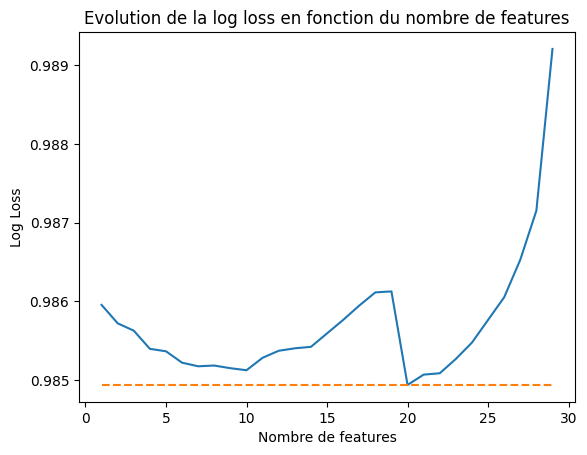

In [22]:
start_idx = 5
plt.plot(range(1, len(log_losses[start_idx:]) + 1), log_losses[start_idx:])
plt.plot(range(1, len(log_losses[start_idx:]) + 1), [min(log_losses[start_idx:])] * len(log_losses[start_idx:]), linestyle='--')
plt.xlabel('Nombre de features')
plt.ylabel('Log Loss')
plt.title('Evolution de la log loss en fonction du nombre de features')
plt.show()

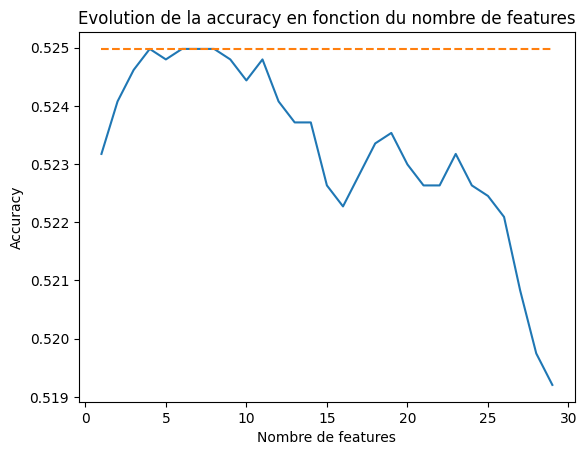

In [24]:
start_idx = 5
plt.plot(range(1, len(accuracys[start_idx:]) + 1), accuracys[start_idx:])
plt.plot(range(1, len(accuracys[start_idx:]) + 1), [max(accuracys[start_idx:])] * len(accuracys[start_idx:]), linestyle='--')
plt.xlabel('Nombre de features')
plt.ylabel('Accuracy')
plt.title('Evolution de la accuracy en fonction du nombre de features')
plt.show()

In [28]:
fbref_results_df__sofifa_merged__data_formated__signals_added__train.sort_values(by='date', ascending=False,)

,game_id,league,season,game,round,week,day,date,time,home_team,...,avg_home_team_goals_season_to_date_before_match,avg_away_team_goals_season_to_date_before_match,glicko2_home_before,glicko2_away_before,glicko2_rd_home_before,glicko2_rd_away_before,glicko2_vol_home_before,glicko2_vol_away_before,trueskill_home_before,trueskill_away_before
32027,d701a1df,ENG-Premier League,2425,2024-09-22 Brighton-Nott'ham Forest,None,5.0,Sun,2024-09-22,14:00:00,Brighton,...,2.000000,1.000000,1515.602728,1473.531909,28.362822,28.038235,0.059746,0.059927,22.926341,20.973783
32009,f247334b,GER-Bundesliga,2425,2024-09-22 Leverkusen-Wolfsburg,None,4.0,Sun,2024-09-22,15:30:00,Leverkusen,...,3.000000,1.500000,1625.054651,1512.374104,28.206051,28.167261,0.059512,0.059476,25.584566,22.230838
32010,4e23f1b6,GER-Bundesliga,2425,2024-09-22 St. Pauli-RB Leipzig,None,4.0,Sun,2024-09-22,19:30:00,St. Pauli,...,0.333333,1.333333,1451.506165,1618.047898,28.977387,28.326699,0.059970,0.059733,16.912497,25.141058
32026,d7538020,ENG-Premier League,2425,2024-09-22 Manchester City-Arsenal,None,5.0,Sun,2024-09-22,16:30:00,Manchester City,...,2.333333,1.500000,1743.889031,1662.230919,26.262846,27.983059,0.059422,0.059405,28.069498,26.299605
32015,2c1f7af3,ITA-Serie A,2425,2024-09-22 Roma-Udinese,None,5.0,Sun,2024-09-22,18:00:00,Roma,...,0.500000,2.000000,1606.020314,1486.297356,27.966634,28.537915,0.059418,0.059404,24.093236,22.037402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,36cd8447,ITA-Serie A,0607,2006-09-09 Fiorentina-Inter,None,1.0,Sat,2006-09-09,None,Fiorentina,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
5,880e137f,ENG-Premier League,0607,2006-09-09 Everton-Liverpool,None,4.0,Sat,2006-09-09,None,Everton,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
16,ffc11029,ESP-La Liga,0607,2006-09-09 Atlético Madrid-Valencia,None,2.0,Sat,2006-09-09,None,Atlético Madrid,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000
17,60c88132,FRA-Ligue 1,0607,2006-09-09 Nantes-Lille,None,5.0,Sat,2006-09-09,None,Nantes,...,0.000000,0.000000,1500.000000,1500.000000,350.000000,350.000000,0.060000,0.060000,0.000000,0.000000


In [53]:
teams = np.sort(fbref_results_df__sofifa_merged__data_formated__signals_added__train["home_team"].unique())
teams

array(['Ajaccio', 'Alavés', 'Albania', 'Almería', 'Amiens', 'Angers',
       'Argentina', 'Arles-Avignon', 'Arminia', 'Arsenal', 'Aston Villa',
       'Atalanta', 'Athletic Club', 'Atlético Madrid', 'Augsburg',
       'Australia', 'Austria', 'Auxerre', 'Barcelona', 'Bari', 'Bastia',
       'Bayern Munich', 'Belgium', 'Benevento', 'Birmingham City',
       'Blackburn', 'Blackpool', 'Bochum', 'Bologna', 'Bolton',
       'Bordeaux', 'Boulogne', 'Bournemouth', 'Braunschweig', 'Brazil',
       'Brentford', 'Brescia', 'Brest', 'Brighton', 'Burnley', 'Caen',
       'Cagliari', 'Cameroon', 'Canada', 'Cardiff City', 'Carpi',
       'Catania', 'Celta Vigo', 'Cesena', 'Chelsea', 'Chievo', 'Chile',
       'Clermont Foot', 'Colombia', 'Costa Rica', 'Cremonese', 'Croatia',
       'Crotone', 'Crystal Palace', 'Czechia', 'Cádiz', 'Córdoba',
       'Darmstadt 98', 'Denmark', 'Dijon', 'Dortmund', 'Düsseldorf',
       'Ecuador', 'Egypt', 'Eibar', 'Eint Frankfurt', 'Elche', 'Empoli',
       'England', 'Es

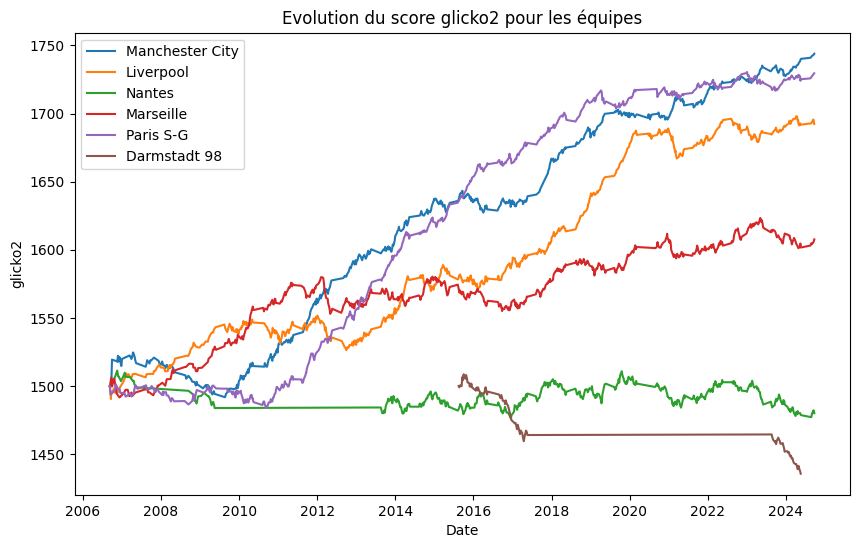

In [59]:
team_names = ['Manchester City', 'Liverpool', 'Nantes', 'Marseille', 'Paris S-G', 'Darmstadt 98']
dfs = []
for team_name in team_names:
    #team_name = 'Manchester City'
    metric_home = 'glicko2_home_before'
    metric_away = 'glicko2_away_before'
    metric = 'glicko2'
    df = fbref_results_df__sofifa_merged__data_formated__signals_added__train
    df_clicko_home = df[(df['home_team'] == team_name)][[metric_home,"date"]]
    df_clicko_away = df[(df['away_team'] == team_name)][[metric_away,"date"]]
    df_clicko_home = df_clicko_home.rename(columns={metric_home: metric})
    df_clicko_away = df_clicko_away.rename(columns={metric_away: metric})
    df_clicko_home["team"] = team_name
    df_clicko_away["team"] = team_name
    df_clicko = pd.concat([df_clicko_home, df_clicko_away])
    df_clicko = df_clicko.sort_values(by='date', ascending=True)
    df_clicko = df_clicko.reset_index(drop=True)
    dfs.append(df_clicko)
plt.figure(figsize=(10, 6))
for df in dfs:
    plt.plot(df['date'], df[metric], label=df['team'][0])
plt.xlabel('Date')
plt.ylabel(metric)
plt.title(f'Evolution du score {metric} pour les équipes')
plt.legend()
plt.show()

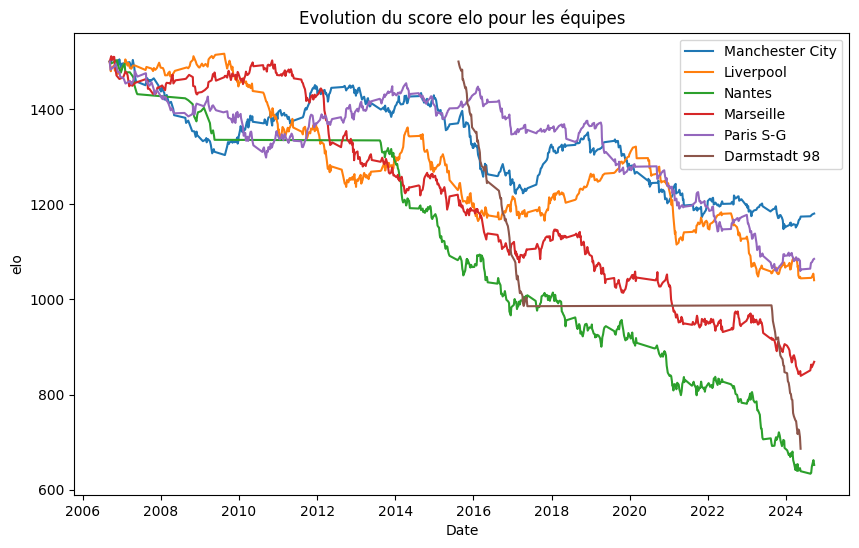

In [65]:
team_names = ['Manchester City', 'Liverpool', 'Nantes', 'Marseille', 'Paris S-G', 'Darmstadt 98']
dfs = []
for team_name in team_names:
    #team_name = 'Manchester City'
    metric_home = 'elo_home_before'
    metric_away = 'elo_away_before'
    metric = 'elo'
    df = fbref_results_df__sofifa_merged__data_formated__signals_added__train
    df_clicko_home = df[(df['home_team'] == team_name)][[metric_home,"date"]]
    df_clicko_away = df[(df['away_team'] == team_name)][[metric_away,"date"]]
    df_clicko_home = df_clicko_home.rename(columns={metric_home: metric})
    df_clicko_away = df_clicko_away.rename(columns={metric_away: metric})
    df_clicko_home["team"] = team_name
    df_clicko_away["team"] = team_name
    df_clicko = pd.concat([df_clicko_home, df_clicko_away])
    df_clicko = df_clicko.sort_values(by='date', ascending=True)
    df_clicko = df_clicko.reset_index(drop=True)
    dfs.append(df_clicko)
plt.figure(figsize=(10, 6))
for df in dfs:
    plt.plot(df['date'], df[metric], label=df['team'][0])
plt.xlabel('Date')
plt.ylabel(metric)
plt.title(f'Evolution du score {metric} pour les équipes')
plt.legend()
plt.show()

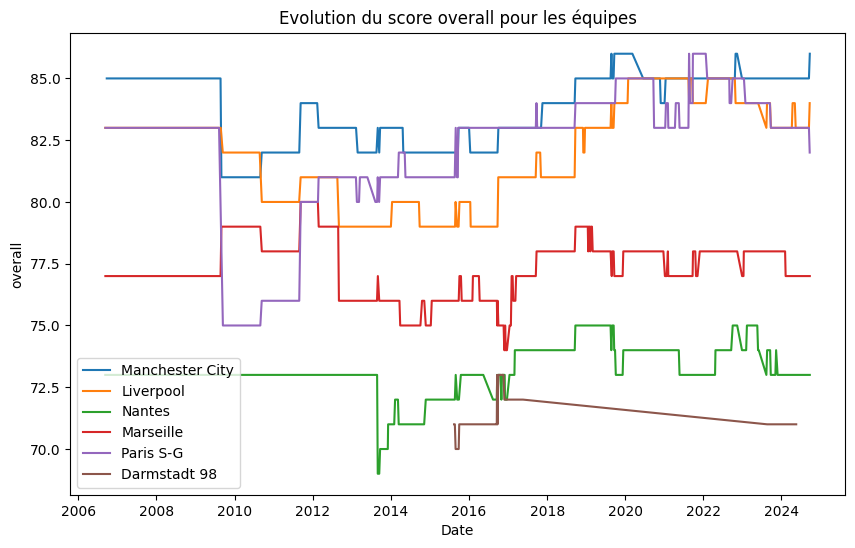

In [61]:
team_names = ['Manchester City', 'Liverpool', 'Nantes', 'Marseille', 'Paris S-G', 'Darmstadt 98']
dfs = []
for team_name in team_names:
    #team_name = 'Manchester City'
    metric_home = 'home_overall'
    metric_away = 'away_overall'
    metric = 'overall'
    df = fbref_results_df__sofifa_merged__data_formated__signals_added__train
    df_clicko_home = df[(df['home_team'] == team_name)][[metric_home,"date"]]
    df_clicko_away = df[(df['away_team'] == team_name)][[metric_away,"date"]]
    df_clicko_home = df_clicko_home.rename(columns={metric_home: metric})
    df_clicko_away = df_clicko_away.rename(columns={metric_away: metric})
    df_clicko_home["team"] = team_name
    df_clicko_away["team"] = team_name
    df_clicko = pd.concat([df_clicko_home, df_clicko_away])
    df_clicko = df_clicko.sort_values(by='date', ascending=True)
    df_clicko = df_clicko.reset_index(drop=True)
    dfs.append(df_clicko)
plt.figure(figsize=(10, 6))
for df in dfs:
    plt.plot(df['date'], df[metric], label=df['team'][0])
plt.xlabel('Date')
plt.ylabel(metric)
plt.title(f'Evolution du score {metric} pour les équipes')
plt.legend()
plt.show()

glicko2
glicko2
glicko2
glicko2
glicko2
glicko2
elo
elo
elo
elo
elo
elo
overall
overall
overall
overall
overall
overall


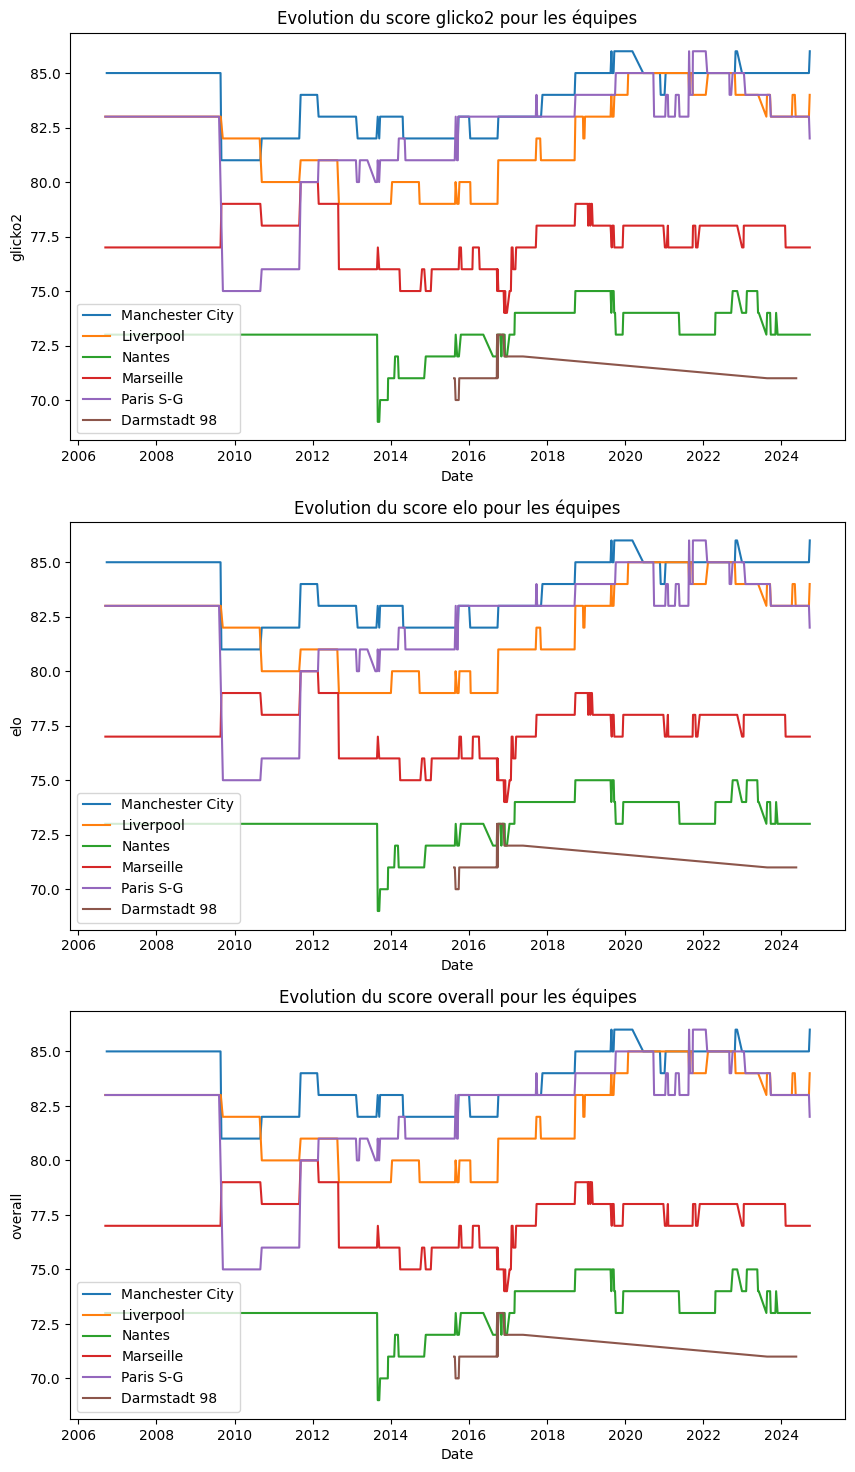

In [64]:
team_names = ['Manchester City', 'Liverpool', 'Nantes', 'Marseille', 'Paris S-G', 'Darmstadt 98']
metrics = ['glicko2', 'elo', 'overall']
metrics_home = ['glicko2_home_before', 'elo_home_before', 'home_overall']
metrics_away = ['glicko2_away_before', 'elo_away_before', 'away_overall']

fig, ax = plt.subplots(3, 1, figsize=(10, 18))
for metric, metric_home, metric_away in zip(metrics, metrics_home, metrics_away):
    dfs = []
    for team_name in team_names:
        #team_name = 'Manchester City'
        metric_home = metric_home
        metric_away = metric_away
        #metric = 'overall'
        print(metric)
        df = fbref_results_df__sofifa_merged__data_formated__signals_added__train
        df_clicko_home = df[(df['home_team'] == team_name)][[metric_home,"date"]]
        df_clicko_away = df[(df['away_team'] == team_name)][[metric_away,"date"]]
        df_clicko_home = df_clicko_home.rename(columns={metric_home: metric})
        df_clicko_away = df_clicko_away.rename(columns={metric_away: metric})
        df_clicko_home["team"] = team_name
        df_clicko_away["team"] = team_name
        df_clicko = pd.concat([df_clicko_home, df_clicko_away])
        df_clicko = df_clicko.sort_values(by='date', ascending=True)
        df_clicko = df_clicko.reset_index(drop=True)
        dfs.append(df_clicko)
    for df in dfs:
        ax[metrics.index(metric)].plot(df['date'], df[metric], label=df['team'][0])
    ax[metrics.index(metric)].set_xlabel('Date')
    ax[metrics.index(metric)].set_ylabel(metric)
    ax[metrics.index(metric)].set_title(f'Evolution du score {metric} pour les équipes')
    ax[metrics.index(metric)].legend()

plt.show()

